In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
from scipy.signal import convolve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configurations for Cubic Map and model
class Config:
    a_chaotic = 2.5
    a_non_chaotic = 1.5
    a_C_T = 2.59
    a_NC_T = 1.4
    x0 = np.random.rand()
    length = 5000


    # Model parameters
    input_shape = (10000, 1)
    num_classes = 2  # Binary classification
    learning_rate = 1e-4
    l2_lambda = 0.001

    # File paths
    data_file_path = 'truncated_audio_files_and_labels_esc50_Cubic.npz'
    #best_model_path = 'best_model_ESC50.keras'
    best_model_path = 'best_model_ESC50_proposed2.keras'
    best_model_path_1 = 'shallow_1.keras'
    best_model_path_2 = 'mlp_2.keras'
    best_model_path_3 = 'fcn_3.keras'
    best_model_path_4 = 'resnet_4.keras'
    best_model_path_5 = 'lkcnn_5.keras'
    best_model_path_new = 'best_model_Cubic_ESC50proposed_2.keras'
    best_model_path_r = 'best_model_resnet2.keras'
    best_model_path_s = 'best_model_cubic_ssdnet1d.keras'
    best_model_path_i = 'best_model_cubic_Incnet1d.keras'
    best_model_path_m2 = 'best_model_cubic_Incnet1dm2.keras'
    best_model_path_rtssd = 'best_model_esc50_restssd_cubic.keras'


In [ ]:
# Loading data
metadata = pd.read_csv('/content/drive/MyDrive/ESC-50-Experiments/ESC-50-master/meta/esc50.csv')
#metadata = pd.read_csv('/content/drive/MyDrive/ESC-50/esc50.csv')
le = LabelEncoder()
metadata['label'] = le.fit_transform(metadata['category'])

In [ ]:
def load_audio_file(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        return audio
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading {file_path}: {e}")
        return None

In [ ]:
# Function to load audio files and labels with detailed debug information
def load_ESC50(data_path, metadata):
    audio_files = []
    labels = []
    for index, row in metadata.iterrows():
        # Directly access the filename without fold subdirectories
        file_path = os.path.join(data_path, row['filename'])
        audio = load_audio_file(file_path)
        audio_files.append(audio)
        labels.append(row['label'])
    return audio_files, np.array(labels)

In [ ]:
# Load audio files and labels
audio_files, labels = load_ESC50('/content/drive/MyDrive/ESC-50-Experiments/ESC-50-master/audio', metadata)
#audio_files, labels = load_ESC50('/content/drive/MyDrive/ESC-50/audio', metadata)

In [ ]:
# Truncating audio files
min_length = min(len(audio) for audio in audio_files)
audio_files_truncated = [audio[:10000] for audio in audio_files]

In [ ]:
# Converting to numpy arrays
audio_files_array = np.array(audio_files_truncated)
labels_array = np.array(labels)

In [ ]:
print(min_length)

110250


In [ ]:
# Print the shape of the truncated audio files array and labels array
print(f'Shape of truncated audio files array: {audio_files_array.shape}')
print(f'Shape of labels array: {labels_array.shape}')

Shape of truncated audio files array: (2000, 10000)
Shape of labels array: (2000,)


In [ ]:
# Saving numpy arrays to a file
np.savez(Config.data_file_path, audio_files=audio_files_array, labels=labels_array)

In [ ]:
# Loading arrays
loaded_data = np.load(Config.data_file_path)
audio_files_array = loaded_data['audio_files']
labels_array = loaded_data['labels']

In [ ]:
labels = labels_array

In [ ]:
def cubic_map(a, x0, n):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = a * x[i-1] * (1 - x[i-1]**2)
    return x

In [ ]:
print(f'a_chaotic = {Config.a_chaotic}')
print(f'a_non_chaotic = {Config.a_non_chaotic}')
print(f'x0 = {Config.x0}')
print(f'length = {Config.length}')

a_chaotic = 2.5
a_non_chaotic = 1.5
x0 = 0.46606439763809826
length = 5000


In [ ]:
#Add
print(f'a_chaotic_T = {Config.a_C_T}')
print(f'a_non_chaotic_T = {Config.a_NC_T}')

a_chaotic_T = 2.59
a_non_chaotic_T = 1.4


In [ ]:
chaotic_series = cubic_map(Config.a_chaotic, Config.x0, Config.length)
non_chaotic_series = cubic_map(Config.a_non_chaotic, Config.x0, Config.length)

In [ ]:
#Add
chaotic_series_T = cubic_map(Config.a_C_T, Config.x0, Config.length)
non_chaotic_series_T = cubic_map(Config.a_NC_T, Config.x0, Config.length)

In [ ]:
print(chaotic_series)

[0.4660644  0.91206936 0.38336438 ... 0.27729085 0.63992474 0.94468302]


In [ ]:
print(non_chaotic_series)

[0.4660644  0.54724161 0.57503597 ... 0.57735027 0.57735027 0.57735027]


In [ ]:
#Add
print(chaotic_series_T)
print(non_chaotic_series_T)

[0.4660644  0.94490385 0.26224471 ... 0.63698005 0.98039136 0.09860473]
[0.4660644  0.51075884 0.52852077 ... 0.53452248 0.53452248 0.53452248]


In [ ]:
MAX_chaotic = 0.9622451246058082
chaotic_series_normalized = chaotic_series / MAX_chaotic
print(chaotic_series_normalized)

[0.48435101 0.94785552 0.39840616 ... 0.2881707  0.66503298 0.98174883]


In [ ]:
MAX_non_chaotic = 0.6999241267270464
non_chaotic_series_normalized = non_chaotic_series / MAX_non_chaotic
print(non_chaotic_series_normalized)

[0.66587846 0.78185848 0.82156901 ... 0.82487551 0.82487551 0.82487551]


In [ ]:
#Add
MAX_chaotic = 0.9968904941819331
chaotic_series_normalized_T = chaotic_series_T / MAX_chaotic
print(chaotic_series_normalized_T)

[0.46751815 0.9478512  0.26306271 ... 0.63896692 0.9834494  0.0989123 ]


In [ ]:
#Add
MAX_non_chaotic = 0.7740189554147798
non_chaotic_series_normalized_T = non_chaotic_series_T / MAX_non_chaotic
print(non_chaotic_series_normalized_T)

[0.60213564 0.65987898 0.68282665 ... 0.69058061 0.69058061 0.69058061]


In [ ]:
# Convolution functions
def convolve_with_series(audio, series):
    return convolve(audio, series, mode='same')

In [ ]:
# Convolve each audio sample with chaotic and non-chaotic time series
audio_files_chaotic = [convolve_with_series(audio, chaotic_series_normalized) for audio in audio_files_array]
audio_files_chaotic = np.array(audio_files_chaotic)

In [ ]:
audio_files_non_chaotic = [convolve_with_series(audio, non_chaotic_series_normalized) for audio in audio_files_array]
audio_files_non_chaotic = np.array(audio_files_non_chaotic)

In [ ]:
#Add
# Convolve each audio sample with chaotic and non-chaotic time series
audio_files_chaotic_T = [convolve_with_series(audio, chaotic_series_normalized_T) for audio in audio_files_array]
audio_files_chaotic_T = np.array(audio_files_chaotic_T)

In [ ]:
#Add
audio_files_non_chaotic_T = [convolve_with_series(audio, non_chaotic_series_normalized_T) for audio in audio_files_array]
audio_files_non_chaotic_T = np.array(audio_files_non_chaotic_T)

In [ ]:
def normalize_audio_standard_scaled(audio):
    mean = np.mean(audio)
    std = np.std(audio)
    print(f'Mean: {mean}, Standard Deviation: {std}')
    if(std!=0):
      audio = (audio - mean) / std
    else:
      audio = audio
    min_val = np.min(audio)
    max_val = np.max(audio)
    scaled_audio = 2 * (audio - min_val) / (max_val - min_val) - 1
    print(f'Min Value: {min_val}, Max Value: {max_val}')
    print(f'Scaled Min Value: {np.min(scaled_audio)}, Scaled Max Value: {np.max(scaled_audio)}')
    return scaled_audio

In [ ]:
audio_files_chaotic_normalized = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_chaotic])
audio_files_non_chaotic_normalized = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_non_chaotic])

Mean: 0.0, Standard Deviation: 0.0
Min Value: 0.0, Max Value: 0.0
Scaled Min Value: nan, Scaled Max Value: nan
Mean: 0.011739656599066681, Standard Deviation: 1.363646246184369
Min Value: -4.118672097638673, Max Value: 4.005074318132601
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 1.2167808253679882, Standard Deviation: 4.846710913525242
Min Value: -3.2907297924807573, Max Value: 3.6388421540777154
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 4.03779553414012, Standard Deviation: 16.435712594949475
Min Value: -2.746560359594966, Max Value: 3.0948497658647103
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.022519491073549183, Standard Deviation: 0.1260249519141276
Min Value: -3.439731514153618, Max Value: 3.1190715333787904
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 0.020062087879291913, Standard Deviation: 0.07183180459665643
Min Value: -2.9836026939096465, Max Value: 3.253014198923526
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -2.604450565496383,

<ipython-input-32-a8798967b480>:11: RuntimeWarning: invalid value encountered in divide
  scaled_audio = 2 * (audio - min_val) / (max_val - min_val) - 1


Streaming output truncated to the last 5000 lines.
Min Value: -1.7356304436353038, Max Value: 2.6069658335592334
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.24880387955957775, Standard Deviation: 0.93157647150549
Min Value: -2.6303845171083338, Max Value: 2.9346290317393056
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -2.7347829406855735, Standard Deviation: 3.1221281271707726
Min Value: -2.0893635897668723, Max Value: 2.2778443102381227
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -1.0791098748832084, Standard Deviation: 1.7013842541705884
Min Value: -2.3088432732618673, Max Value: 1.7853567504958692
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 0.32512397409077787, Standard Deviation: 1.3450827374079162
Min Value: -3.182863654340111, Max Value: 2.9965086677732784
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.6973363726765746, Standard Deviation: 2.2282749581349264
Min Value: -2.992282663910992, Max Value: 2.818668080016359
Scaled Min Value: -1.

In [ ]:
#Add
audio_files_chaotic_normalized_T = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_chaotic_T])
audio_files_non_chaotic_normalized_T = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_non_chaotic_T])

Mean: 0.0, Standard Deviation: 0.0
Min Value: 0.0, Max Value: 0.0
Scaled Min Value: nan, Scaled Max Value: nan
Mean: 0.009130700885938103, Standard Deviation: 3.4910630159913247
Min Value: -4.340987148091479, Max Value: 3.9432548895760102
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 0.9767213690209757, Standard Deviation: 5.768335563448657
Min Value: -3.6205023677350368, Max Value: 3.612368985456268
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 3.3023744577704304, Standard Deviation: 14.06883791909686
Min Value: -3.2090549452631065, Max Value: 3.5783059491870812
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.018379327441286227, Standard Deviation: 0.1590251062618481
Min Value: -3.6565873964044333, Max Value: 4.183956104159654
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 0.016417128075886963, Standard Deviation: 0.07007752514547519
Min Value: -3.4251733489464704, Max Value: 3.1208400508612093
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -2.115767289387

<ipython-input-32-a8798967b480>:11: RuntimeWarning: invalid value encountered in divide
  scaled_audio = 2 * (audio - min_val) / (max_val - min_val) - 1


Streaming output truncated to the last 5000 lines.
Min Value: -1.7333085600944464, Max Value: 2.6195016876766983
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.2082923414396927, Standard Deviation: 0.7796706271688072
Min Value: -2.632833109665224, Max Value: 2.927588280074448
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -2.2895678262751056, Standard Deviation: 2.6139033897159627
Min Value: -2.0908320095765323, Max Value: 2.275108353901794
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.9034448444246982, Standard Deviation: 1.4244011775102114
Min Value: -2.314395771065519, Max Value: 1.785659912634954
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 0.27219282589464766, Standard Deviation: 1.1261916698664944
Min Value: -3.1831818165926165, Max Value: 2.9945700387690994
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.5838231417955705, Standard Deviation: 1.8657867525574743
Min Value: -2.9918099521523103, Max Value: 2.822534400870707
Scaled Min Value: -1.0,

In [ ]:
# Function to plot the waveform of an audio file
def plot_waveform(audio, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
# Function to load and return audio as numpy array
def load_audio(file_path, sr=22050):
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

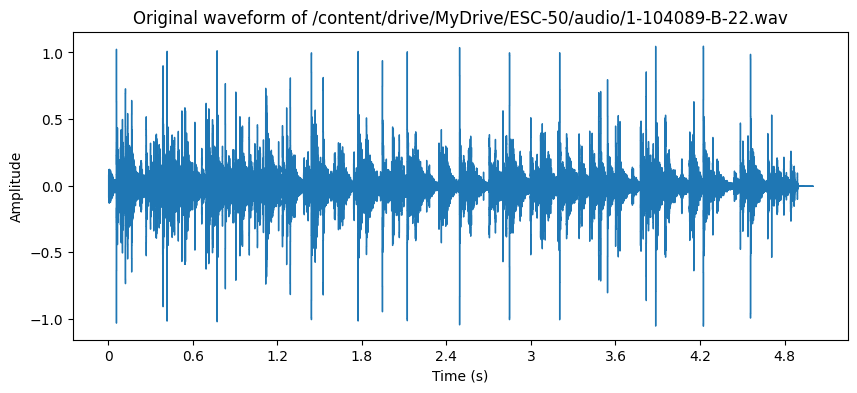

In [ ]:
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
# List of audio file paths
audio_files = [
    '/content/drive/MyDrive/ESC-50/audio/1-104089-B-22.wav',
    '/content/drive/MyDrive/ESC-50/audio/1-103298-A-9.wav',
    '/content/drive/MyDrive/ESC-50/audio/1-46938-B-7.wav',
    '/content/drive/MyDrive/ESC-50/audio/2-92978-A-29.wav'
]
#Then load the audio file
file_path = audio_files[0]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

Mean: -1.6047852113842964e-05, Standard Deviation: 0.08568460494279861
Min Value: -12.065035820007324, Max Value: 12.25649642944336
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -25.7621000424313, Standard Deviation: 1.8490850880813545
Min Value: -3.0368234005601926, Max Value: 7.956141032860059
Scaled Min Value: -1.0, Scaled Max Value: 1.0


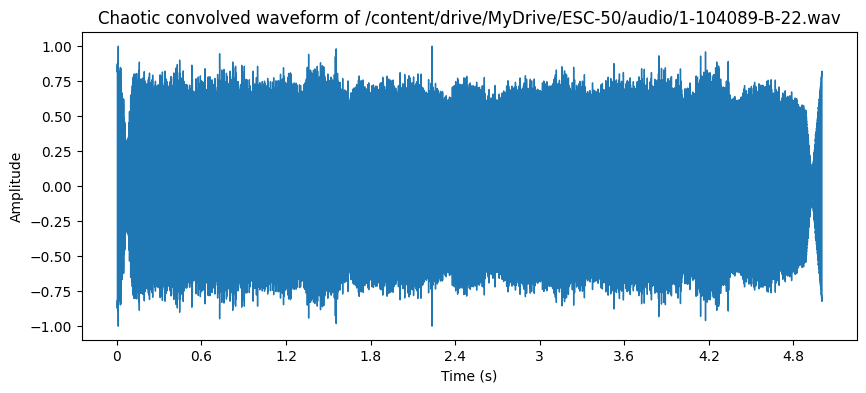

Mean: -32.09333578932817, Standard Deviation: 1.9789226434591423
Min Value: -2.3004142473593916, Max Value: 8.149239034212755
Scaled Min Value: -1.0, Scaled Max Value: 1.0


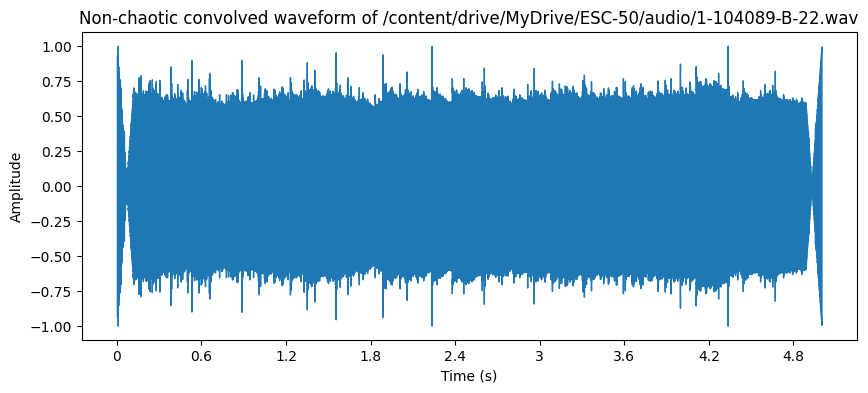

In [ ]:
# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

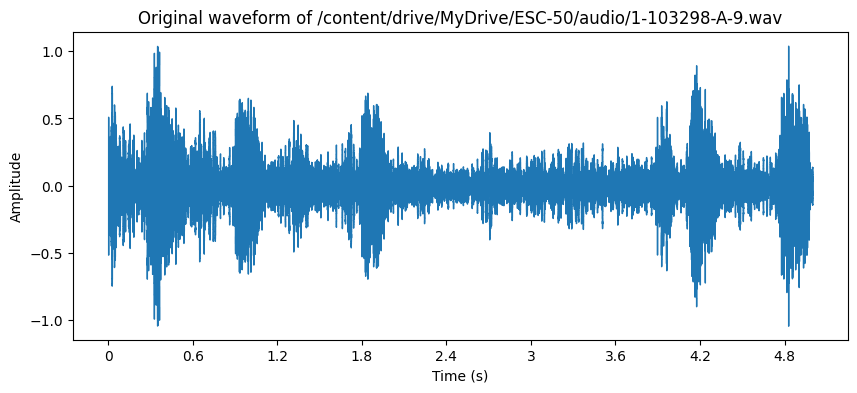

Mean: -0.00025358353741467, Standard Deviation: 0.13610254228115082
Min Value: -6.576225280761719, Max Value: 7.644897937774658
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -245.98757558354365, Standard Deviation: 23.04968741877459
Min Value: -2.7129663258258563, Max Value: 5.357675746870299
Scaled Min Value: -1.0, Scaled Max Value: 1.0


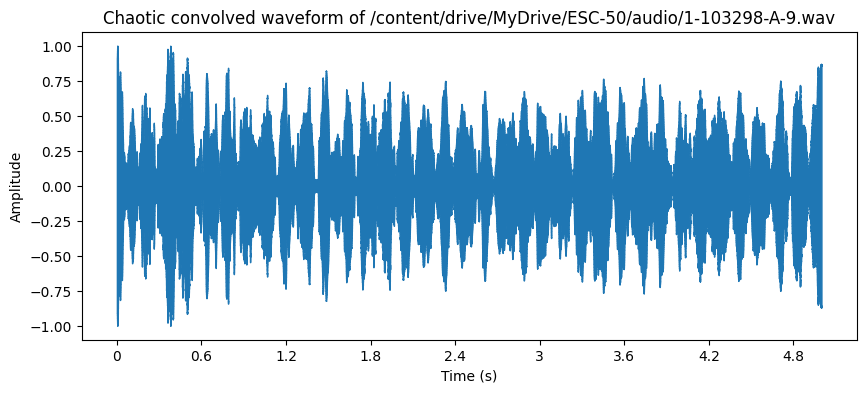

Mean: -306.44322655308724, Standard Deviation: 28.77651151331392
Min Value: -2.5260285207854674, Max Value: 5.281523192540427
Scaled Min Value: -1.0, Scaled Max Value: 1.0


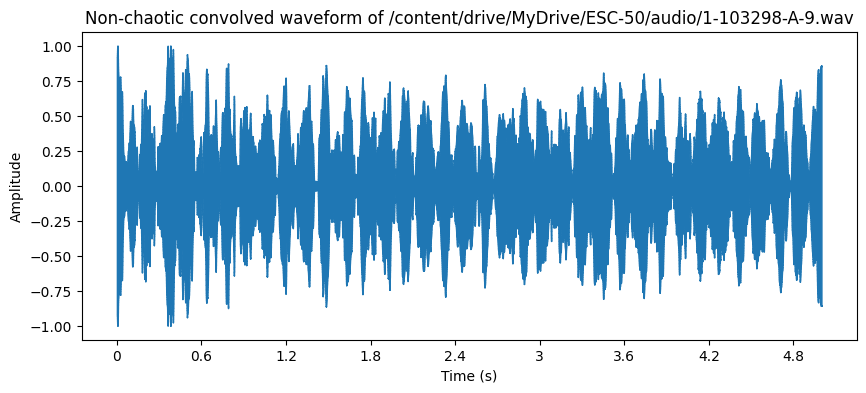

In [ ]:
file_path = audio_files[1]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

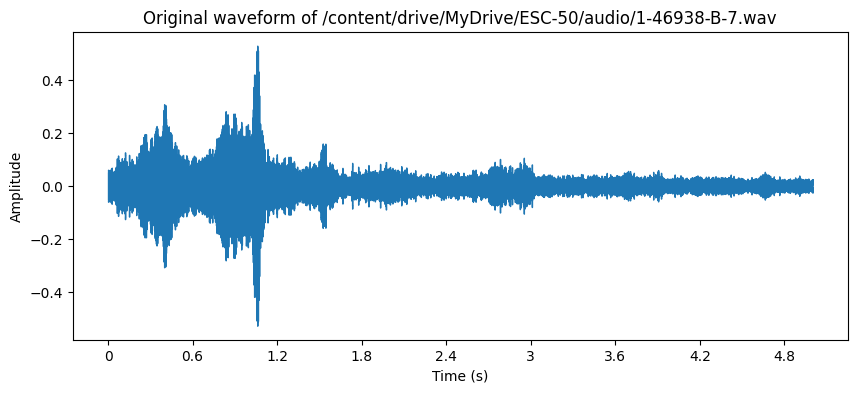

Mean: 0.000393329857615754, Standard Deviation: 0.03892510384321213
Min Value: -13.557897567749023, Max Value: 10.927544593811035
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 351.6462363921208, Standard Deviation: 21.937874573402883
Min Value: -8.00834248857542, Max Value: 0.8554183489330704
Scaled Min Value: -1.0, Scaled Max Value: 1.0


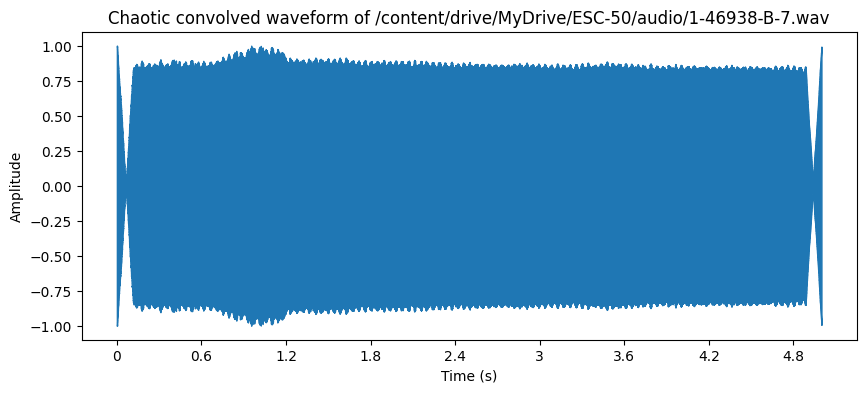

Mean: 438.0659729774026, Standard Deviation: 27.34675723710944
Min Value: -8.025084141937674, Max Value: 0.6794864588627698
Scaled Min Value: -1.0, Scaled Max Value: 1.0


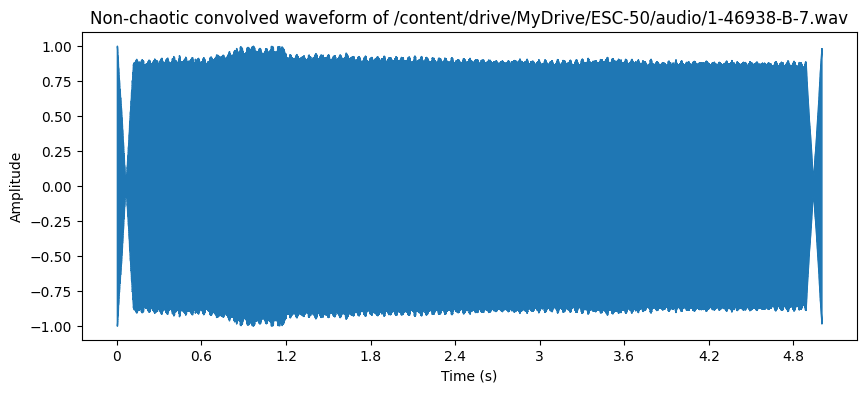

In [ ]:
file_path = audio_files[2]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

In [ ]:
# Binary classification labels
labels_chaotic = np.ones(len(labels_array))
labels_non_chaotic = np.zeros(len(labels_array))

In [ ]:
# Concatenating audio files and labels
audio_files_augmented = np.concatenate((audio_files_chaotic_normalized, audio_files_non_chaotic_normalized), axis=0)
labels_augmented = np.concatenate((labels_chaotic, labels_non_chaotic), axis=0)

In [ ]:
#Add
# Concatenating audio files and labels
audio_files_augmented_T = np.concatenate((audio_files_chaotic_normalized_T, audio_files_non_chaotic_normalized_T), axis=0)
labels_augmented_T = np.concatenate((labels_chaotic, labels_non_chaotic), axis=0)

In [ ]:
# Encoding labels
encoder = LabelEncoder()
labels_augmented_encoded = encoder.fit_transform(labels_augmented)

In [ ]:
#Add
# Encoding labels
encoder = LabelEncoder()
labels_augmented_encoded_T = encoder.fit_transform(labels_augmented_T)

In [ ]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(audio_files_augmented, labels_augmented_encoded, test_size=0.2, random_state=42)

In [ ]:
# Adding channel dimension for 1D CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
#Add
# Adding channel dimension for 1D CNN
X = audio_files_augmented_T[..., np.newaxis]
y = labels_augmented_encoded_T

In [ ]:
# Removing NaN values
def remove_nan_samples(X, y):
    mask = ~np.isnan(X).any(axis=(1, 2))
    return X[mask], y[mask]

In [ ]:
X_train, y_train = remove_nan_samples(X_train, y_train)
X_test, y_test = remove_nan_samples(X_test, y_test)

In [ ]:
#Add
X, y = remove_nan_samples(X, y)

# Use the entire dataset as the test set
X_test_T = X
y_test_T = y

# Print shapes to verify
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Print shapes to verify
print(f"X_test shape: {X_test_T.shape}")
print(f"y_test shape: {y_test_T.shape}")

X_test shape: (796, 10000, 1)
y_test shape: (796,)
X_test shape: (3976, 10000, 1)
y_test shape: (3976,)


Model-1: ShallowNet

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

# Define the shallow neural network model
def create_shallownet(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input
    model.add(Dense(100, activation='sigmoid', input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Create the model
model_shallownet = create_shallownet(Config.input_shape)
model_shallownet.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_shallownet.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100)                 │       1,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,201 (3.82 MB)

 Trainable params: 1,000,201 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model- for a_NC=1.5, a_C=2
checkpoint_1 = ModelCheckpoint(Config.best_model_path_1, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history_1 = model_shallownet.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_1])

Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4923 - loss: 0.7406
Epoch 1: val_accuracy improved from -inf to 0.48428, saving model to shallow_1.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4923 - loss: 0.7405 - val_accuracy: 0.4843 - val_loss: 0.7165
Epoch 2/60
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5561 - loss: 0.6965
Epoch 2: val_accuracy did not improve from 0.48428
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5555 - loss: 0.6968 - val_accuracy: 0.4324 - val_loss: 0.7210
Epoch 3/60
54/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5649 - loss: 0.6832
Epoch 3: val_accuracy did not improve from 0.48428
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5652 - loss: 0.6846 - val_accuracy: 0.4151 - val_loss: 0.7406
Epoch 4/60
56/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5850 - loss: 0.6763
Epoch 4: val_accuracy did not improve from 0.48428
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5851 - loss: 0.6762 - val_

In [ ]:
# Evaluate the model- for a_NC=1.5, a_C=2
model_shallownet.load_weights(Config.best_model_path_1)
loss, accuracy = model_shallownet.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4960 - loss: 0.7103 
Test loss: 0.7110590934753418
Test accuracy: 0.4886934757232666


In [ ]:
#Add
# Evaluate the model- for a_NC=1.4, a_C=2.59
model_shallownet.load_weights(Config.best_model_path_1)
loss, accuracy = model_shallownet.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7081 - loss: 0.6448
Test loss: 0.6978284120559692
Test accuracy: 0.5432595610618591


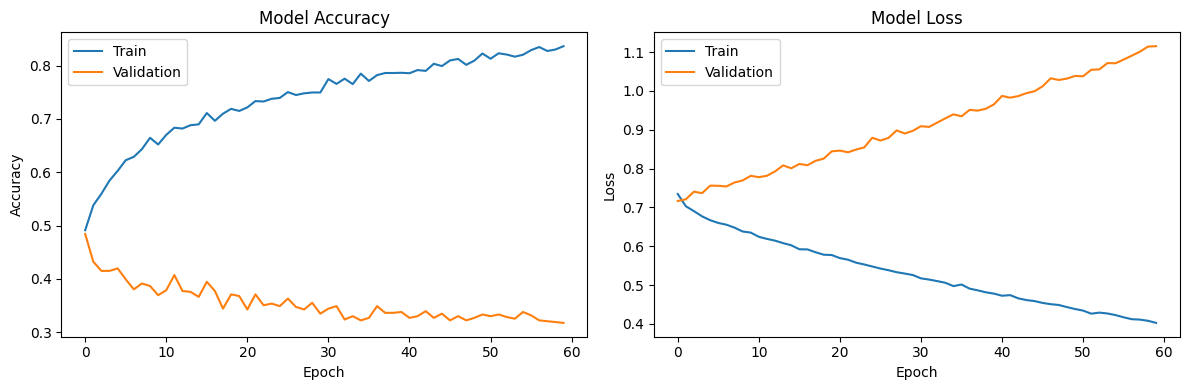

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_1):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_1.history['accuracy'])
    plt.plot(history_1.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_1.history['loss'])
    plt.plot(history_1.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming `history` contains the training history from model.fit
plot_training_history(history_1)

Model-2:MLP

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the MLP model
def create_mlp(input_shape):
    model = Sequential()

    # Input dropout
    model.add(Input(shape=input_shape))
    model.add(Dropout(0.1))

    # Flatten the input
    model.add(Flatten())

    # First hidden layer
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))

    # Second hidden layer
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))

    # Third hidden layer
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    model.add(Dropout(0.3))

    return model

# Create the model
model_mlp = create_mlp(Config.input_shape)
model_mlp.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_mlp.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_3 (Dropout)                  │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 500)                 │       5,000,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             501 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,502,001 (20.99 MB)

 Trainable params: 5,502,001 (20.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model- for a_NC=1.5, a_C=2
checkpoint_2 = ModelCheckpoint(Config.best_model_path_2, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history_2 = model_mlp.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_2])

Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5352 - loss: 2.9563
Epoch 1: val_accuracy improved from -inf to 0.51572, saving model to mlp_2.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.5353 - loss: 2.9554 - val_accuracy: 0.5157 - val_loss: 0.8135
Epoch 2/60
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5670 - loss: 3.0419
Epoch 2: val_accuracy did not improve from 0.51572
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5670 - loss: 3.0397 - val_accuracy: 0.5157 - val_loss: 0.8278
Epoch 3/60
69/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5578 - loss: 2.7437
Epoch 3: val_accuracy did not improve from 0.51572
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5571 - loss: 2.7572 - val_accuracy: 0.5126 - val_loss: 0.7568
Epoch 4/60
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5885 - loss: 2.7133
Epoch 4: val_accuracy did not improve from 0.51572
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5881 - loss: 2.7147 - val_acc

In [ ]:
# Evaluate the model- for a_NC=1.5, a_C=2
model_mlp.load_weights(Config.best_model_path_2)
loss, accuracy = model_mlp.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4629 - loss: 0.8474
Test loss: 0.8521219491958618
Test accuracy: 0.4673366844654083


In [ ]:
#Add
# Evaluate the model- for a_NC=1.4, a_C=2.59
model_mlp.load_weights(Config.best_model_path_2)
loss, accuracy = model_mlp.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1633 - loss: 1.0111
Test loss: 0.7482236623764038
Test accuracy: 0.49924546480178833


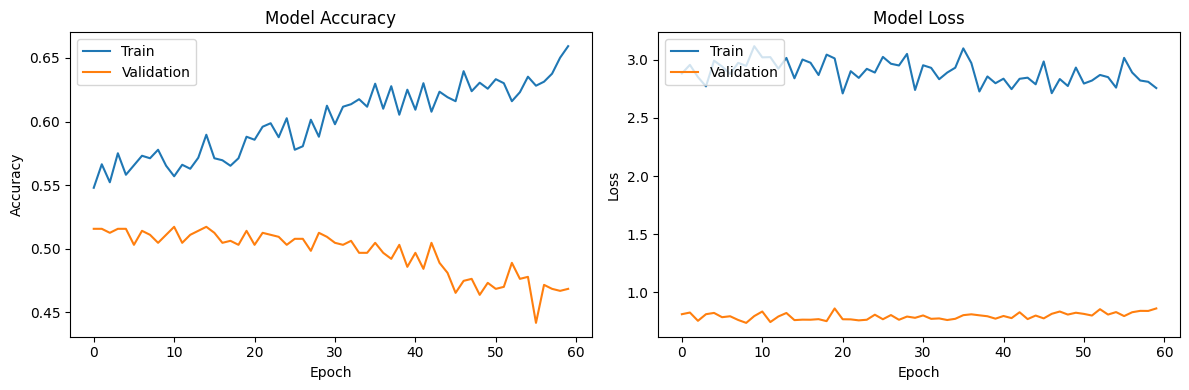

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_2):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_2.history['accuracy'])
    plt.plot(history_2.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_2.history['loss'])
    plt.plot(history_2.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming `history` contains the training history from model.fit
plot_training_history(history_2)

Model-3:FCN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Softmax
from tensorflow.keras.optimizers import Adam

def create_fcn_model(input_shape):
    inputs = Input(shape=input_shape)

    # First convolutional block
    x = Conv1D(filters=64, kernel_size=8, strides=1, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolutional block
    x = Conv1D(filters=128, kernel_size=5, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third convolutional block
    x = Conv1D(filters=64, kernel_size=3, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Global average pooling layer
    x = GlobalAveragePooling1D()(x)

    # Softmax layer (classification layer)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
# Create the model
model_fcn =  create_fcn_model(Config.input_shape)
model_fcn.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_fcn.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_42 (Conv1D)                   │ (None, 9993, 64)            │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 9993, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 9993, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ (None, 9989, 128)           │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 9989, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 9989, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_44 (Conv1D)                   │ (None, 9987, 64)            │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 9987, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 9987, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,393 (263.25 KB)

 Trainable params: 66,881 (261.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Training the model- for a_NC=1.5, a_C=2
checkpoint_3 = ModelCheckpoint(Config.best_model_path_3, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history_3 = model_fcn.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_3])

Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6475 - loss: 0.6234
Epoch 1: val_accuracy improved from -inf to 0.51572, saving model to fcn_3.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.6479 - loss: 0.6230 - val_accuracy: 0.5157 - val_loss: 0.7090
Epoch 2/60
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7149 - loss: 0.5655
Epoch 2: val_accuracy did not improve from 0.51572
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7149 - loss: 0.5652 - val_accuracy: 0.5157 - val_loss: 0.7404
Epoch 3/60
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7294 - loss: 0.5403
Epoch 3: val_accuracy did not improve from 0.51572
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.7298 - loss: 0.5399 - val_accuracy: 0.5157 - val_loss: 0.7395
Epoch 4/60
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7699 - loss: 0.4967
Epoch 4: val_accuracy improved from 0.51572 to 0.55346, saving model to fcn_3.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - 

In [ ]:
# Evaluate the model- for a_NC=1.5, a_C=2
model_fcn.load_weights(Config.best_model_path_3)
loss, accuracy = model_fcn.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8340 - loss: 0.3724
Test loss: 0.36910128593444824
Test accuracy: 0.8429648280143738


In [ ]:
#Add
# Evaluate the model- for a_NC=1.4, a_C=2.59
model_fcn.load_weights(Config.best_model_path_3)
loss, accuracy = model_fcn.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7836 - loss: 0.4173
Test loss: 0.43789100646972656
Test accuracy: 0.821177065372467


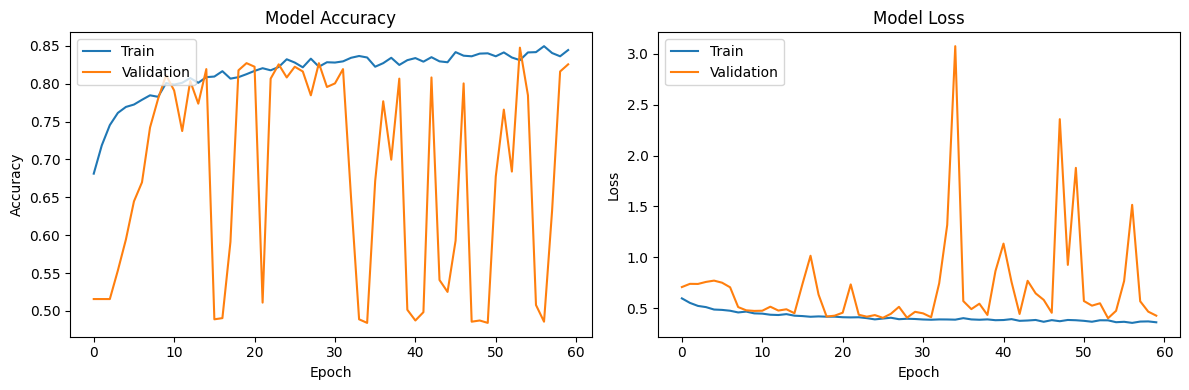

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_3):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_3.history['accuracy'])
    plt.plot(history_3.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_3.history['loss'])
    plt.plot(history_3.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming `history` contains the training history from model.fit
plot_training_history(history_3)

Model-4:LKCNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, ReLU

def create_lkcnn(input_shape):
    model = Sequential()

    # First convolutional layer
    model.add(Conv1D(filters=5, kernel_size=100, padding='same', input_shape=input_shape))
    model.add(ReLU())

    # Second convolutional layer
    model.add(Conv1D(filters=5, kernel_size=100, padding='same'))
    model.add(ReLU())

    # Max pooling layer
    model.add(MaxPooling1D(pool_size=2))

    # Dropout layer
    model.add(Dropout(0.5))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(100))
    model.add(ReLU())

    # Fully connected layer 2
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    return model

In [ ]:
# Create the model
model_lkcnn = create_lkcnn(Config.input_shape)
model_lkcnn.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_lkcnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 10000, 5)            │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 10000, 5)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 10000, 5)            │           2,505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 10000, 5)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5000, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5000, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │       2,500,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,503,211 (9.55 MB)

 Trainable params: 2,503,211 (9.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
checkpoint_5 = ModelCheckpoint(Config.best_model_path_5, monitor='val_accuracy', save_best_only=True, mode='max')
history_5 = model_lkcnn.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_5])

Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.5345 - loss: 0.6954 - val_accuracy: 0.6604 - val_loss: 0.6489
Epoch 2/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6860 - loss: 0.6047 - val_accuracy: 0.6871 - val_loss: 0.6137
Epoch 3/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7537 - loss: 0.5274 - val_accuracy: 0.7311 - val_loss: 0.5474
Epoch 4/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7693 - loss: 0.4799 - val_accuracy: 0.7374 - val_loss: 0.5299
Epoch 5/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7856 - loss: 0.4421 - val_accuracy: 0.7516 - val_loss: 0.5111
Epoch 6/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.7959 - loss: 0.4246 - val_accuracy: 0.7579 - val_loss: 0.5147
Epoch 7/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8154 - loss: 0.4021 - val_accuracy: 0.7689 - val_loss: 0.5052
Epoch 8/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8227 - loss: 0.3743 - val_accuracy: 0.7736 - 

In [ ]:
# Evaluate the model- for a_NC=1.5, a_C=2
model_lkcnn.load_weights(Config.best_model_path_5)
loss, accuracy = model_lkcnn.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8243 - loss: 0.5138
Test loss: 0.4928356409072876
Test accuracy: 0.8291457295417786


In [ ]:
#Add
# Evaluate the model- for a_NC=1.4, a_C=2.59
model_lkcnn.load_weights(Config.best_model_path_5)
loss, accuracy = model_lkcnn.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9136 - loss: 0.2539
Test loss: 0.2901293635368347
Test accuracy: 0.9215291738510132


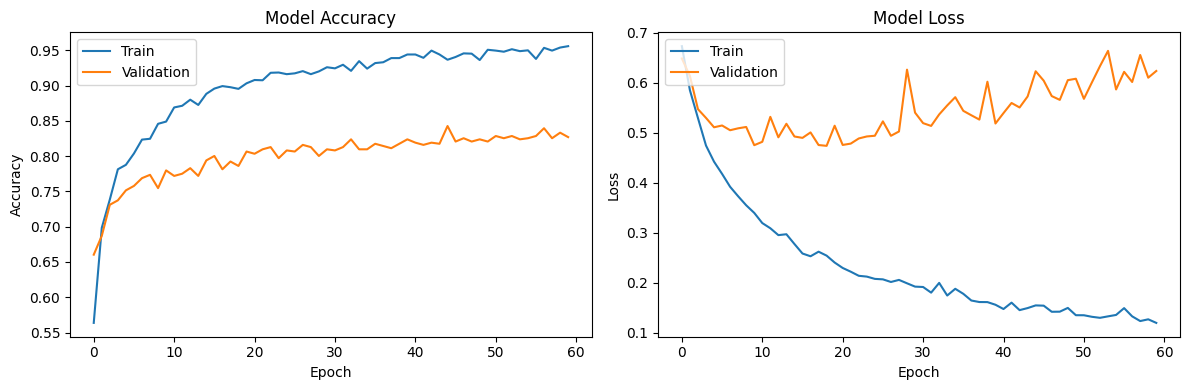

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_5):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_5.history['accuracy'])
    plt.plot(history_5.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_5.history['loss'])
    plt.plot(history_5.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_5)

Proposed-2: Adding attention in between residual blocks

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Activation, Bidirectional, Add, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
#from tensorflow_addons.layers import WeightNormalization

class Attention(Layer):
    def _init_(self, **kwargs):
        super(Attention, self)._init_(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x + x * a  # Adding skip connection
        #return K.sum(output, axis=1)
        return output


def residual_block(x, filters, kernel_size, dilation_rate, pool_size):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(Config.l2_lambda))(x)     #Removing Weight Normalization
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(Config.l2_lambda))(x)     #Removing Weight Normalization
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size)(x)
    shortcut = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(Config.l2_lambda))(shortcut)                              #Removing Weight Normalization
    shortcut = MaxPooling1D(pool_size)(shortcut)
    x = Add()([x, shortcut])
    return x

def create_network_with_attention_and_dilation(input_shape):
    input_layer = Input(shape=input_shape)

    # CNN part with residual blocks and dilation
    x = residual_block(input_layer, 64, 3, 1, 2)#Add attention layer between the blocks
    x = Attention()(x)
    x = residual_block(x, 128, 3, 2, 2)
    x = Attention()(x)
    x = residual_block(x, 256, 3, 4, 2)
    x = Dropout(0.3)(x)

    # Batch normalization before the start of BiLSTM layers
    x = BatchNormalization()(x)

    # BiLSTM part
    #x = Bidirectional(LSTM(128, return_sequences=True))(x)
    #x = Bidirectional(LSTM(128, return_sequences=True))(x)

    # Batch normalization after the BiLSTM layers
    #x = BatchNormalization()(x)

    # Attention layer
    x = Attention()(x)
    x = BatchNormalization()(x)

    # Global Average Pooling layer
    x = GlobalAveragePooling1D()(x)  # This reduces the dimensions

    # Dense Projection
    x = (Dense(128, activation='relu', kernel_regularizer=l2(Config.l2_lambda))(x))                                             #Removing Weight Normalization
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# Instantiate and compile the model
model_att_with_dil_2 = create_network_with_attention_and_dilation(Config.input_shape)
model_att_with_dil_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_att_with_dil_2.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 10000, 1)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_33 (Conv1D)        │ (None, 10000, 64)      │            256 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 10000, 64)      │            256 │ conv1d_33[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 10000, 64)      │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_34 (Conv1D)        │ (None, 10000, 64)      │         12,352 │ activation_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 10000, 64)      │            256 │ conv1d_34[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 10000, 64)      │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_35 (Conv1D)        │ (None, 10000, 64)      │            128 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 5000, 64)       │              0 │ activation_10[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 5000, 64)       │              0 │ conv1d_35[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 5000, 64)       │              0 │ max_pooling1d_5[0][0], │
│                           │                        │                │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 5000, 64)       │          4,160 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_36 (Conv1D)        │ (None, 5000, 128)      │         24,704 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 5000, 128)      │            512 │ conv1d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 5000, 128)      │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 548,609 (2.09 MB)

 Trainable params: 545,793 (2.08 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
# Train the model
checkpoint_new = ModelCheckpoint(Config.best_model_path_new, monitor='val_accuracy', save_best_only=True, mode='max')
history_new = model_att_with_dil_2.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_new])

Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 518ms/step - accuracy: 0.7124 - loss: 1.6748 - val_accuracy: 0.5157 - val_loss: 2.0846
Epoch 2/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 228ms/step - accuracy: 0.8063 - loss: 1.5413 - val_accuracy: 0.5157 - val_loss: 2.5405
Epoch 3/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.8099 - loss: 1.4854 - val_accuracy: 0.5157 - val_loss: 2.6168
Epoch 4/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.8201 - loss: 1.4583 - val_accuracy: 0.5896 - val_loss: 1.8922
Epoch 5/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.8378 - loss: 1.3995 - val_accuracy: 0.6965 - val_loss: 1.6169
Epoch 6/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - accuracy: 0.8372 - loss: 1.3845 - val_accuracy: 0.6981 - val_loss: 1.5795
Epoch 7/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - accuracy: 0.8582 - loss: 1.3258 - val_accuracy: 0.6903 - val_loss: 1.5647
Epoch 8/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - accuracy: 0.8484 - loss: 1.3165 - val_accu

In [ ]:
# Evaluate the model- for a_NC=1.5, a_C=2
model_att_with_dil_2.load_weights(Config.best_model_path_new)
loss, accuracy = model_att_with_dil_2.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8751 - loss: 0.8047
Test loss: 0.8062055706977844
Test accuracy: 0.873115599155426


In [ ]:
#Add
# Evaluate the model- for a_NC=1.4, a_C=2.59
model_att_with_dil_2.load_weights(Config.best_model_path_new)
loss, accuracy = model_att_with_dil_2.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.7264 - loss: 1.0804
Test loss: 0.9946077466011047
Test accuracy: 0.7826961874961853


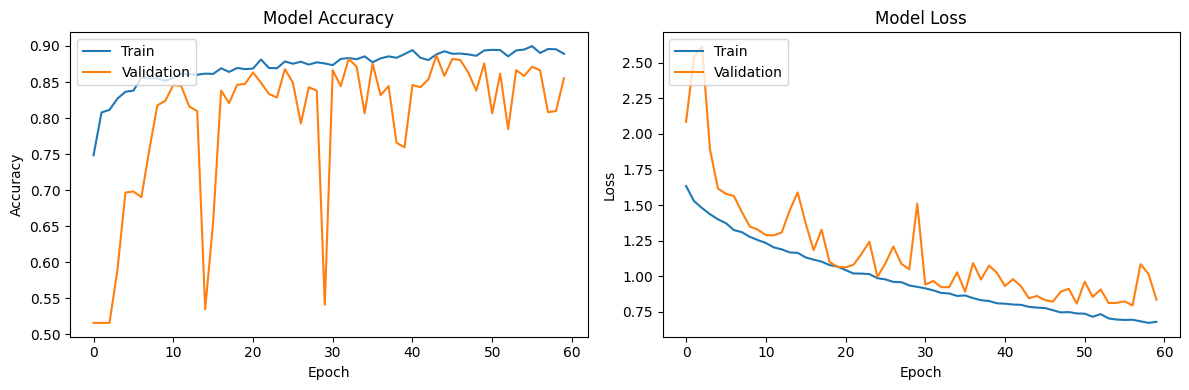

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_new):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_new.history['accuracy'])
    plt.plot(history_new.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_new.history['loss'])
    plt.plot(history_new.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_new)

**ResNet-2**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Add, Activation, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam

def fcn_block(x, filters, kernel_size):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def residual_block(x, filters, kernel_size):
    shortcut = x
    x = fcn_block(x, filters, kernel_size)
    x = fcn_block(x, filters, kernel_size)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv1D(filters=filters, kernel_size=1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def create_resnet(input_shape, nb_classes=1):
    inputs = Input(shape=input_shape)
    x = BatchNormalization()(inputs)

    # First residual block with 64 filters
    x = residual_block(x, 64, 8)

    # Second residual block with 128 filters
    x = residual_block(x, 128, 5)

    # Third residual block with 128 filters
    x = residual_block(x, 128, 3)

    # Global average pooling layer
    x = GlobalAveragePooling1D()(x)

    # Dense layer with sigmoid activation for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Instantiate and compile the model
model_resnet2 = create_resnet(Config.input_shape)
model_resnet2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_resnet2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 10000, 1)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 10000, 1)       │              4 │ input_layer_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 10000, 64)      │            576 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 10000, 64)      │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 10000, 64)      │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 10000, 64)      │         32,832 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 10000, 64)      │            256 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 10000, 64)      │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 10000, 64)      │         32,832 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 10000, 64)      │            128 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 10000, 64)      │            256 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 10000, 64)      │            256 │ conv1d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 10000, 64)      │              0 │ batch_normalization_4… │
│                           │                        │                │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 10000, 64)      │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 10000, 128)     │         41,088 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 10000, 128)     │            512 │ conv1d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 432,453 (1.65 MB)

 Trainable params: 430,147 (1.64 MB)

 Non-trainable params: 2,306 (9.01 KB)

In [ ]:
# Train the model
checkpoint_r = ModelCheckpoint(Config.best_model_path_r, monitor='val_accuracy', save_best_only=True, mode='max')
history_r = model_resnet2.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_r])

Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 539ms/step - accuracy: 0.7114 - loss: 0.5759 - val_accuracy: 0.5157 - val_loss: 0.7113
Epoch 2/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 324ms/step - accuracy: 0.7857 - loss: 0.4564 - val_accuracy: 0.5252 - val_loss: 0.7267
Epoch 3/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 320ms/step - accuracy: 0.8492 - loss: 0.3692 - val_accuracy: 0.7107 - val_loss: 0.5614
Epoch 4/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 317ms/step - accuracy: 0.8618 - loss: 0.3423 - val_accuracy: 0.8145 - val_loss: 0.4183
Epoch 5/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - accuracy: 0.8774 - loss: 0.2900 - val_accuracy: 0.8365 - val_loss: 0.3688
Epoch 6/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 332ms/step - accuracy: 0.8894 - loss: 0.2890 - val_accuracy: 0.8616 - val_loss: 0.3517
Epoch 7/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 322ms/step - accuracy: 0.8799 - loss: 0.3033 - val_accuracy: 0.8931 - val_loss: 0.3052
Epoch 8/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - accuracy: 0.8855 - loss: 0.2636 - val_accu

In [ ]:
# Evaluate the model- for r_NC=3.5, r_C=3.7
model_resnet2.load_weights(Config.best_model_path_r)
loss, accuracy = model_resnet2.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9238 - loss: 0.1945
Test loss: 0.1859322041273117
Test accuracy: 0.9346733689308167


In [ ]:
#Add
# Evaluate the model- for r_NC=3.4, r_C=3.8
model_resnet2.load_weights(Config.best_model_path_r)
loss, accuracy = model_resnet2.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.6977 - loss: 0.6263
Test loss: 0.44871604442596436
Test accuracy: 0.7977867126464844


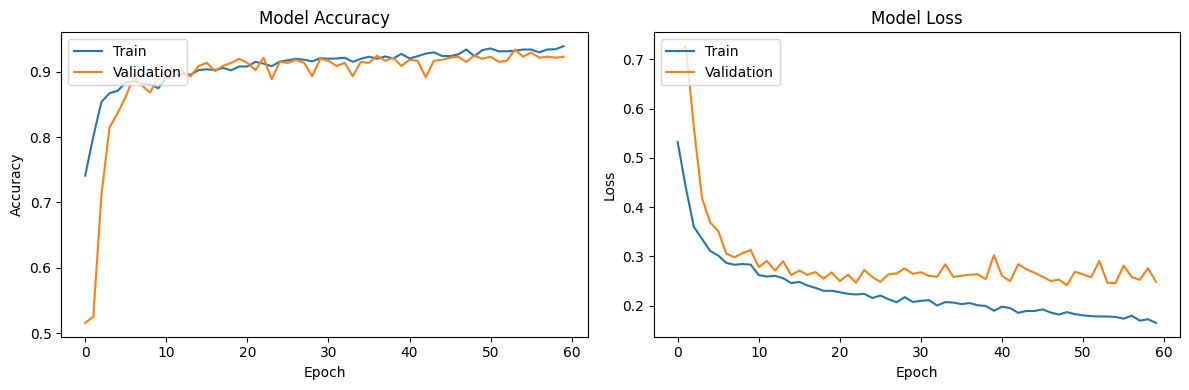

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_r):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_r.history['accuracy'])
    plt.plot(history_r.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_r.history['loss'])
    plt.plot(history_r.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_r)

**Res-TSSDNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

#ResNet-Style Module 1D
class RSM1D(layers.Layer):
    def __init__(self, channels_in, channels_out):
        super(RSM1D, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.nin = layers.Conv1D(filters=channels_out, kernel_size=1, use_bias=False)

    def call(self, x):
        y = tf.nn.relu(self.bn1(self.conv1(x)))
        y = tf.nn.relu(self.bn2(self.conv2(y)))
        y = self.conv3(y)
        x = self.nin(x)
        x = tf.nn.relu(self.bn3(x + y))
        return x

#Res-TSSDNet
#class SSDNet1D(models.Model):
    #def __init__(self):
        # super(SSDNet1D, self).__init__()
        # self.conv1 = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False)
        # self.bn1 = layers.BatchNormalization()
        # self.RSM1 = RSM1D(16, 32)
        # self.RSM2 = RSM1D(32, 64)
        # self.RSM3 = RSM1D(64, 128)
        # self.RSM4 = RSM1D(128, 128)
        # self.fc1 = layers.Dense(64)
        # self.fc2 = layers.Dense(32)
        # self.out = layers.Dense(2)

    # def call(self, x):
    #     x = tf.nn.relu(self.bn1(self.conv1(x)))
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     #stacked ResNet-Style Modules
    #     x = self.RSM1(x)
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     x = self.RSM2(x)
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     x = self.RSM3(x)
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     x = self.RSM4(x)
    #     x = tf.nn.max_pool1d(x, pool_size=375, strides=375, padding='same')
    #     x = layers.Flatten()(x)
    #     x = tf.nn.relu(self.fc1(x))
    #     x = tf.nn.relu(self.fc2(x))
    #     x = self.out(x)
    #     return x

#Res-TSSDNet
def create_ssdnet1d(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    #x = tf.nn.relu(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked ResNet-Style Modules
    x = RSM1D(16, 32)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(32, 64)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(128, 128)(x)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Flatten()(x)
    #x = tf.nn.relu(layers.Dense(64)(x))
    x = layers.Dense(64)(x)
    x = layers.ReLU()(x)


    #x = tf.nn.relu(layers.Dense(32)(x))
    x = layers.Dense(32)(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # For binary classification

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Create the model with the specified input shape
model_ssdnet1d = create_ssdnet1d(Config.input_shape)
model_ssdnet1d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate),loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_ssdnet1d.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_47 (Conv1D)                   │ (None, 10000, 16)           │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 10000, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 10000, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 2500, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d (RSM1D)                        │ (None, 2500, 32)            │           8,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 625, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d_1 (RSM1D)                      │ (None, 625, 64)             │          33,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 157, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d_2 (RSM1D)                      │ (None, 157, 128)            │         132,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d_3 (RSM1D)                      │ (None, 40, 128)             │         165,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_11 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 350,641 (1.34 MB)

 Trainable params: 348,497 (1.33 MB)

 Non-trainable params: 2,144 (8.38 KB)

In [ ]:
# Train the model
checkpoint_s = ModelCheckpoint(Config.best_model_path_s, monitor='val_accuracy', save_best_only=True, mode='max')
history_s = model_ssdnet1d.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_s])

Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.6534 - loss: 0.6208 - val_accuracy: 0.5157 - val_loss: 0.7077
Epoch 2/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.7651 - loss: 0.4851 - val_accuracy: 0.5157 - val_loss: 0.7322
Epoch 3/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7919 - loss: 0.4386 - val_accuracy: 0.5959 - val_loss: 0.6907
Epoch 4/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8208 - loss: 0.3857 - val_accuracy: 0.6399 - val_loss: 0.6967
Epoch 5/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8254 - loss: 0.3920 - val_accuracy: 0.6745 - val_loss: 0.7265
Epoch 6/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8456 - loss: 0.3456 - val_accuracy: 0.6903 - val_loss: 0.7612
Epoch 7/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8680 - loss: 0.3171 - val_accuracy: 0.7233 - val_loss: 0.6741
Epoch 8/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8591 - loss: 0.3317 - val_accuracy: 0.7516 

In [ ]:
# Evaluate the model- for a_NC=1.5, a_C=2.5
model_ssdnet1d.load_weights(Config.best_model_path_s)
loss, accuracy = model_ssdnet1d.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8299 - loss: 0.6324
Test loss: 0.5821784138679504
Test accuracy: 0.8341708779335022


In [ ]:
#Add
# Evaluate the model- for a_NC=1.4, a_C=2.59
model_ssdnet1d.load_weights(Config.best_model_path_s)
loss, accuracy = model_ssdnet1d.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8074 - loss: 0.6174
Test loss: 0.42654895782470703
Test accuracy: 0.8707243204116821


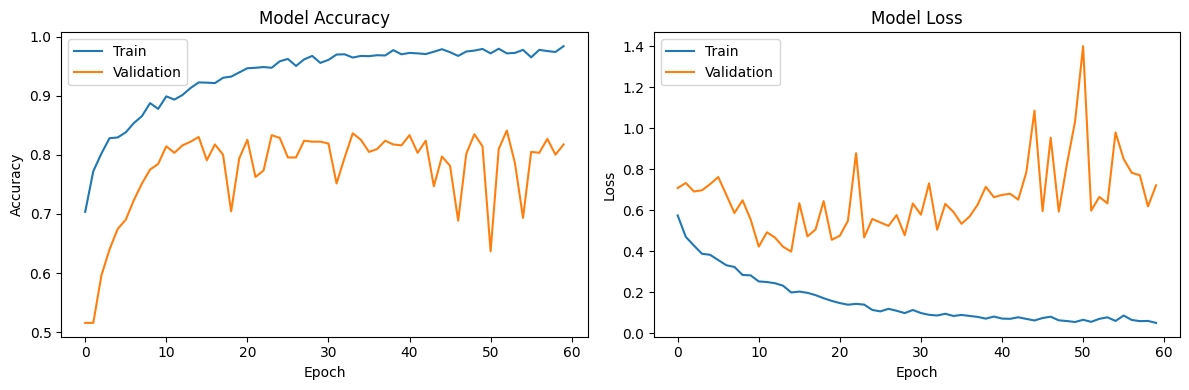

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_s):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_s.history['accuracy'])
    plt.plot(history_s.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_s.history['loss'])
    plt.plot(history_s.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_s)

**Inc-TSSDNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Dilated Convolution Module 1D (equivalent to ISM1D in the previous code)
class DilatedConvModule(layers.Layer):
    def __init__(self, channels_in, channels_out1, channels_out2, channels_out3, channels_out4):
        super(DilatedConvModule, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out1, kernel_size=3, padding='same', dilation_rate=1, use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out2, kernel_size=3, padding='same', dilation_rate=2, use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out3, kernel_size=3, padding='same', dilation_rate=4, use_bias=False)
        self.conv4 = layers.Conv1D(filters=channels_out4, kernel_size=3, padding='same', dilation_rate=8, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()

    def call(self, x):
        y1 = tf.nn.relu(self.bn1(self.conv1(x)))
        y2 = tf.nn.relu(self.bn2(self.conv2(x)))
        y3 = tf.nn.relu(self.bn3(self.conv3(x)))
        y4 = tf.nn.relu(self.bn4(self.conv4(x)))
        y = tf.concat([y1, y2, y3, y4], axis=-1)
        return y

# Inc-TSSDNet
def create_inc_tssdnet(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    #x = tf.nn.relu(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked Dilated Convolution Modules
    # x = DilatedConvModule(16, 32)(x)
    # x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    # x = DilatedConvModule(32, 64)(x)
    # x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    # x = DilatedConvModule(64, 128)(x)
    # x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    # x = DilatedConvModule(128, 128)(x)
    # x = layers.GlobalMaxPooling1D()(x)

    # Stacked Dilated Convolution Modules
    x = DilatedConvModule(16, 16, 32, 64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(240, 32, 64, 128, 256)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(480, 64, 128, 256, 512)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(960, 128, 256, 512, 1024)(x)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Flatten()(x)
    #x = tf.nn.relu(layers.Dense(64)(x))
    x = layers.Dense(64)(x)
    x = layers.ReLU()(x)
    #x = tf.nn.relu(layers.Dense(32)(x))
    x = layers.Dense(32)(x)
    x = layers.ReLU()(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)  # For binary classification

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Create the model with the specified input shape
model_Incnet = create_inc_tssdnet(Config.input_shape)
model_Incnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate),loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_Incnet.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 10000, 16)           │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 10000, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 10000, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2500, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module                  │ (None, 2500, 240)           │          12,480 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 625, 240)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module_1                │ (None, 625, 480)            │         347,520 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 157, 480)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module_2                │ (None, 157, 960)            │       1,386,240 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 40, 960)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module_3                │ (None, 40, 1920)            │       5,537,280 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 1920)                │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │         122,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,408,753 (28.26 MB)

 Trainable params: 7,401,521 (28.23 MB)

 Non-trainable params: 7,232 (28.25 KB)

In [ ]:
# Train the model
checkpoint_i = ModelCheckpoint(Config.best_model_path_i, monitor='val_accuracy', save_best_only=True, mode='max')
history_i = model_Incnet.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_i])

Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 451ms/step - accuracy: 0.6867 - loss: 0.6087 - val_accuracy: 0.4843 - val_loss: 0.6914
Epoch 2/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8053 - loss: 0.3950 - val_accuracy: 0.4843 - val_loss: 0.7385
Epoch 3/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8517 - loss: 0.3261 - val_accuracy: 0.6965 - val_loss: 0.5751
Epoch 4/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.8895 - loss: 0.2588 - val_accuracy: 0.7217 - val_loss: 0.5461
Epoch 5/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.9176 - loss: 0.2084 - val_accuracy: 0.7720 - val_loss: 0.4988
Epoch 6/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9183 - loss: 0.2059 - val_accuracy: 0.7453 - val_loss: 0.6819
Epoch 7/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9271 - loss: 0.1731 - val_accuracy: 0.7752 - val_loss: 0.6000
Epoch 8/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9253 - loss: 0.1959 - val_accuracy: 0.7

In [ ]:
# Evaluate the model- for a_NC=1.5, a_C=2.5
model_Incnet.load_weights(Config.best_model_path_i)
loss, accuracy = model_Incnet.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8485 - loss: 0.5354
Test loss: 0.49850544333457947
Test accuracy: 0.8542713522911072


In [ ]:
#Add
# Evaluate the model- for a_NC=1.4, a_C=2.59
model_Incnet.load_weights(Config.best_model_path_i)
loss, accuracy = model_Incnet.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.8334 - loss: 0.5155
Test loss: 0.3334704637527466
Test accuracy: 0.8938632011413574


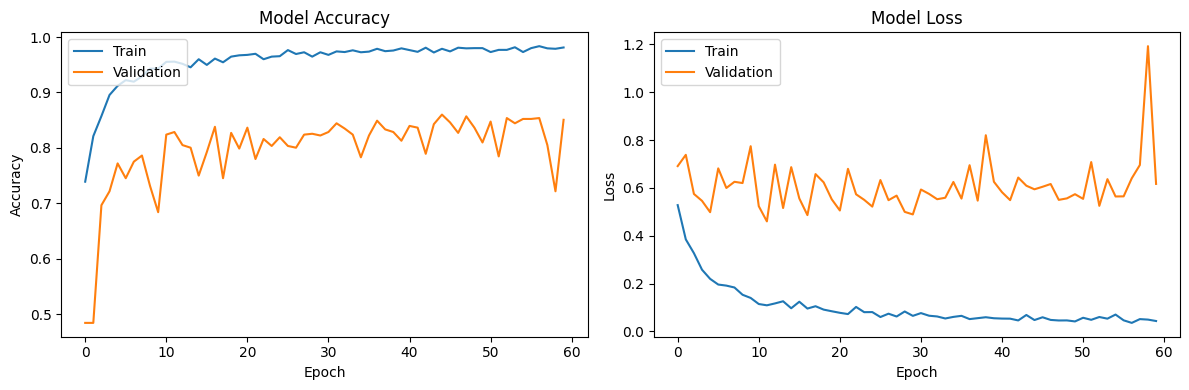

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_i):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_i.history['accuracy'])
    plt.plot(history_i.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_i.history['loss'])
    plt.plot(history_i.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_i)

Mod-IncNet2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# Dilated Convolution Module 1D
class DilatedConvModule(layers.Layer):
    def __init__(self, channels_in, channels_out1, channels_out2, channels_out3, channels_out4, dropout_rate=0.3):
        super(DilatedConvModule, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out1, kernel_size=3, padding='same', dilation_rate=1, use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out2, kernel_size=3, padding='same', dilation_rate=2, use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out3, kernel_size=3, padding='same', dilation_rate=4, use_bias=False)
        self.conv4 = layers.Conv1D(filters=channels_out4, kernel_size=3, padding='same', dilation_rate=8, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        y1 = tf.nn.relu(self.bn1(self.conv1(x), training=training))
        y2 = tf.nn.relu(self.bn2(self.conv2(x), training=training))
        y3 = tf.nn.relu(self.bn3(self.conv3(x), training=training))
        y4 = tf.nn.relu(self.bn4(self.conv4(x), training=training))
        y = tf.concat([y1, y2, y3, y4], axis=-1)
        y = self.dropout(y, training=training)
        return y

# Residual Block
def residual_block(l, increase_dim=False, first=False, keep_filter=False, strides=None, r_value=None, dropout_rate=0.3):
    input_num_filters = tf.keras.backend.int_shape(l)[-1]

    if increase_dim:
        first_stride = strides
        out_num_filters = input_num_filters * 2 if not keep_filter else input_num_filters
    else:
        first_stride = 1
        out_num_filters = input_num_filters

    if not first:
        bn_pre_conv = layers.BatchNormalization()(l)
        bn_pre_relu = layers.LeakyReLU()(bn_pre_conv)
    else:
        bn_pre_relu = l

    conv_1 = layers.LeakyReLU()(
        layers.BatchNormalization()(
            layers.Conv1D(filters=out_num_filters, kernel_size=3, strides=first_stride, padding='same', kernel_regularizer=regularizers.l2(r_value))(bn_pre_relu)
        )
    )

    conv_2 = layers.Conv1D(filters=out_num_filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(r_value))(conv_1)

    if increase_dim:
        projection = layers.Conv1D(filters=out_num_filters, kernel_size=1, strides=first_stride, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(l)
        block = layers.Add()([conv_2, projection])
    else:
        block = layers.Add()([conv_2, l])

    block = layers.Dropout(dropout_rate)(block)
    return block

# Create the model with residual blocks and dilated conv modules
def create_inc_tssdnet_with_residual_and_conv_modules(input_shape, r_value=0.01, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked Dilated Convolution Modules
    x = DilatedConvModule(16, 16, 32, 64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(240, 32, 64, 128, 256)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(480, 64, 128, 256, 512)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(960, 128, 256, 512, 1024)(x)

    # Global MaxPooling
    x = layers.GlobalMaxPooling1D()(x)

    # Residual Blocks
    x = layers.Reshape((1, -1))(x)  # Reshape for 1D Convolution
    x = residual_block(x, first=True, r_value=r_value)
    for _ in range(1, 2):
        x = residual_block(x, r_value=r_value)

    x = residual_block(x, increase_dim=True, strides=2, r_value=r_value)
    for _ in range(1, 2):
        x = residual_block(x, r_value=r_value)

    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Final Layers with Dropout
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.LeakyReLU()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # For binary classification

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Create the model with the specified input shape
model_Incnet_m2 = create_inc_tssdnet_with_residual_and_conv_modules(Config.input_shape, r_value=0.01, dropout_rate=0.5)
model_Incnet_m2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_Incnet_m2.summary()

# Learning Rate Scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Early Stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10000, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10000, 16)      │            112 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10000, 16)      │             64 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 10000, 16)      │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 2500, 16)       │              0 │ leaky_re_lu[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module       │ (None, 2500, 240)      │         12,480 │ max_pooling1d[0][0]    │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 625, 240)       │              0 │ dilated_conv_module[0… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_1     │ (None, 625, 480)       │        347,520 │ max_pooling1d_1[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 157, 480)       │              0 │ dilated_conv_module_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_2     │ (None, 157, 960)       │      1,386,240 │ max_pooling1d_2[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 40, 960)        │              0 │ dilated_conv_module_2… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_3     │ (None, 40, 1920)       │      5,537,280 │ max_pooling1d_3[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 1920)           │              0 │ dilated_conv_module_3… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1920)        │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)   

 Total params: 214,085,233 (816.67 MB)

 Trainable params: 214,031,921 (816.47 MB)

 Non-trainable params: 53,312 (208.25 KB)

In [ ]:
# Model Checkpoint
checkpoint_m2 = callbacks.ModelCheckpoint(Config.best_model_path_m2, monitor='val_accuracy', save_best_only=True, mode='max')
history_m2 = model_Incnet_m2.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_m2, lr_scheduler, early_stopping])

Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.6372 - loss: 198.9964 - val_accuracy: 0.4843 - val_loss: 100.0656 - learning_rate: 1.0000e-04
Epoch 2/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 60s 280ms/step - accuracy: 0.7094 - loss: 83.5024 - val_accuracy: 0.4843 - val_loss: 49.2812 - learning_rate: 1.0000e-04
Epoch 3/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 305ms/step - accuracy: 0.7168 - loss: 42.9745 - val_accuracy: 0.4843 - val_loss: 29.4435 - learning_rate: 1.0000e-04
Epoch 4/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 297ms/step - accuracy: 0.7612 - loss: 26.4106 - val_accuracy: 0.4843 - val_loss: 19.9800 - learning_rate: 1.0000e-04
Epoch 5/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 305ms/step - accuracy: 0.8047 - loss: 18.0881 - val_accuracy: 0.4843 - val_loss: 14.6157 - learning_rate: 1.0000e-04
Epoch 6/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 296ms/step - accuracy: 0.7996 - loss: 13.3083 - val_accuracy: 0.4843 - val_loss: 11.1333 - learning_rate: 1.0000e-04
Epoch 7/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/

In [ ]:
# Evaluate the model
model_Incnet_m2.load_weights(Config.best_model_path_m2)
loss, accuracy = model_Incnet_m2.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7959 - loss: 1.0641
Test loss: 1.062906265258789
Test accuracy: 0.7977386713027954


In [ ]:
#Add
# Evaluate the model- for r_NC=1.1, r_C=1.7
model_Incnet_m2.load_weights(Config.best_model_path_m2)
loss, accuracy = model_Incnet_m2.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.9284 - loss: 0.9773
Test loss: 1.0530328750610352
Test accuracy: 0.8412978053092957


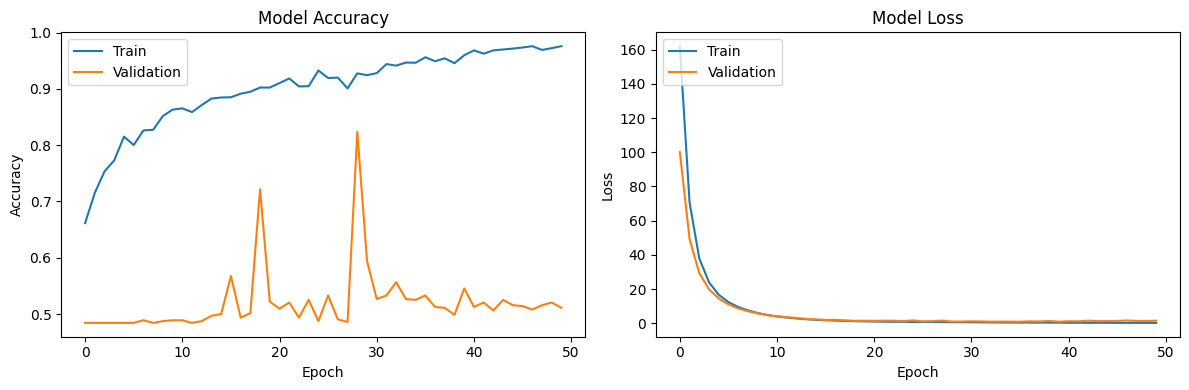

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_m2):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_m2.history['accuracy'])
    plt.plot(history_m2.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_m2.history['loss'])
    plt.plot(history_m2.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_m2)

**Mod-ResTSSDNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# ResNet-Style Module 1D
class RSM1D(layers.Layer):
    def __init__(self, channels_in, channels_out):
        super(RSM1D, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.nin = layers.Conv1D(filters=channels_out, kernel_size=1, use_bias=False)

    def call(self, x):
        y = tf.nn.relu(self.bn1(self.conv1(x)))
        y = tf.nn.relu(self.bn2(self.conv2(y)))
        y = self.conv3(y)
        x = self.nin(x)
        x = tf.nn.relu(self.bn3(x + y))
        return x

# Residual Block
def residual_block(l, increase_dim=False, first=False, keep_filter=False, strides=None, r_value=None, dropout_rate=0.3):
    input_num_filters = tf.keras.backend.int_shape(l)[-1]

    if increase_dim:
        first_stride = strides
        out_num_filters = input_num_filters * 2 if not keep_filter else input_num_filters
    else:
        first_stride = 1
        out_num_filters = input_num_filters

    if not first:
        bn_pre_conv = layers.BatchNormalization()(l)
        bn_pre_relu = layers.LeakyReLU()(bn_pre_conv)
    else:
        bn_pre_relu = l

    conv_1 = layers.LeakyReLU()(
        layers.BatchNormalization()(
            layers.Conv1D(filters=out_num_filters, kernel_size=3, strides=first_stride, padding='same', kernel_regularizer=regularizers.l2(r_value))(bn_pre_relu)
        )
    )

    conv_2 = layers.Conv1D(filters=out_num_filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(r_value))(conv_1)

    if increase_dim:
        projection = layers.Conv1D(filters=out_num_filters, kernel_size=1, strides=first_stride, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(l)
        block = layers.Add()([conv_2, projection])
    else:
        block = layers.Add()([conv_2, l])

    block = layers.Dropout(dropout_rate)(block)
    return block


# Res-TSSDNet
def create_ssdnet1d_with_residual_and_conv_modules(input_shape, r_value=0.01, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False,  kernel_regularizer=regularizers.l2(r_value))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked ResNet-Style Modules
    x = RSM1D(16, 32)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(32, 64)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(128, 128)(x)
    x = layers.GlobalMaxPooling1D()(x)

     # Residual Blocks
    x = layers.Reshape((1, -1))(x)  # Reshape for 1D Convolution
    x = residual_block(x, first=True, r_value=r_value)
    for _ in range(1, 3):
        x = residual_block(x, r_value=r_value)

    x = residual_block(x, increase_dim=True, strides=2, r_value=r_value)
    for _ in range(1, 3):
        x = residual_block(x, r_value=r_value)

    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)


    x = layers.Flatten()(x)
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer for binary classification
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Create the model with the specified input shape
model_Restssd = create_ssdnet1d_with_residual_and_conv_modules(Config.input_shape, r_value=0.01, dropout_rate=0.5)
model_Restssd.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_Restssd.summary()

# Learning Rate Scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Early Stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10000, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10000, 16)      │            112 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10000, 16)      │             64 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 10000, 16)      │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 2500, 16)       │              0 │ re_lu[0][0]            │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d (RSM1D)             │ (None, 2500, 32)       │          8,576 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 625, 32)        │              0 │ rsm1d[0][0]            │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d_1 (RSM1D)           │ (None, 625, 64)        │         33,536 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 157, 64)        │              0 │ rsm1d_1[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d_2 (RSM1D)           │ (None, 157, 128)       │        132,608 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 40, 128)        │              0 │ rsm1d_2[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d_3 (RSM1D)           │ (None, 40, 128)        │        165,376 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ rsm1d_3[0][0]          │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 128)         │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 1, 128)         │         49,280 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 1, 128)         │            512 │ conv1d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,779,377 (6.79 MB)

 Trainable params: 1,772,625 (6.76 MB)

 Non-trainable params: 6,752 (26.38 KB)

In [ ]:
# Model Checkpoint
checkpoint_rtssd = callbacks.ModelCheckpoint(Config.best_model_path_rtssd, monitor='val_accuracy', save_best_only=True, mode='max')
history_rtssd = model_Restssd.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_rtssd, lr_scheduler, early_stopping])

Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 327ms/step - accuracy: 0.5120 - loss: 24.7771 - val_accuracy: 0.5157 - val_loss: 20.7657 - learning_rate: 1.0000e-04
Epoch 2/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5371 - loss: 19.7625 - val_accuracy: 0.5157 - val_loss: 16.7911 - learning_rate: 1.0000e-04
Epoch 3/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5773 - loss: 16.0226 - val_accuracy: 0.5157 - val_loss: 13.7762 - learning_rate: 1.0000e-04
Epoch 4/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5539 - loss: 13.1794 - val_accuracy: 0.5157 - val_loss: 11.4783 - learning_rate: 1.0000e-04
Epoch 5/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5708 - loss: 11.0046 - val_accuracy: 0.5173 - val_loss: 9.7158 - learning_rate: 1.0000e-04
Epoch 6/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5726 - loss: 9.3469 - val_accuracy: 0.5645 - val_loss: 8.3427 - learning_rate: 1.0000e-04
Epoch 7/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accur

In [ ]:
# Evaluate the model
model_Restssd.load_weights(Config.best_model_path_rtssd)
loss, accuracy = model_Restssd.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8654 - loss: 1.0928
Test loss: 1.0820392370224
Test accuracy: 0.8718593120574951


In [ ]:
#Add
# Evaluate the model- for a_NC=1.4, a_C=2.59
model_Restssd.load_weights(Config.best_model_path_rtssd)
loss, accuracy = model_Restssd.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7719 - loss: 1.1443
Test loss: 1.114021897315979
Test accuracy: 0.8548792600631714


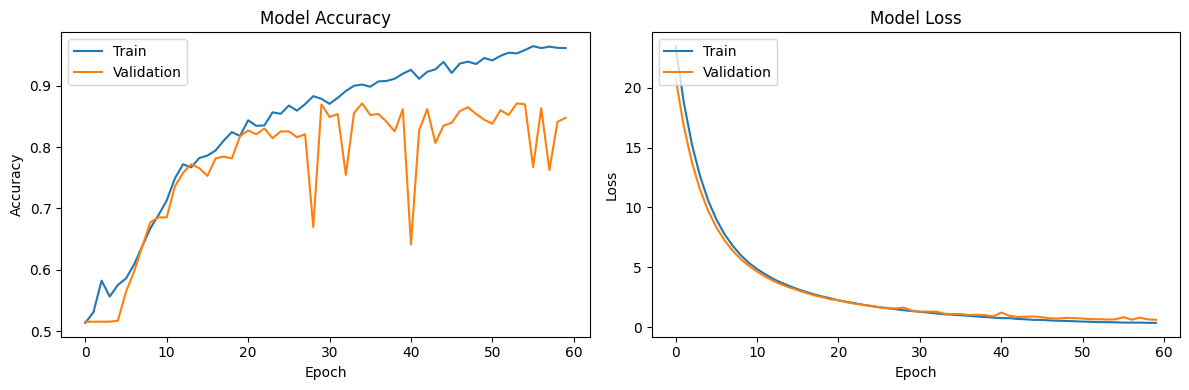

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_rtssd):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_rtssd.history['accuracy'])
    plt.plot(history_rtssd.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_rtssd.history['loss'])
    plt.plot(history_rtssd.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_rtssd)